<a href="https://colab.research.google.com/github/yerriswamys2020/AIML_Lab/blob/main/DeepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Todays observations
#1. I plotted RMSE vs SNR the results are bad, need to check with number of smaples in training and epoch
#2. Activation function Relu, in hidden layers and linear in Output layer is working good
#3. The array implement is end fire array and the possible angles are  from 0 to 180

#21-05-2025 Observation
# 1. I modified generate_data to return correlation matrix and true doas earler it was signals and true doas. Correaltionamtrix os follwed is followed in all research papers
# 2. Today i need to check for first using Unitary transfroamtion and second is use of correlated signals

In [2]:
#Generate Uniform Antenna Array signal model
def generate_data(num_samples, num_antennas, num_sources, signal_dim, snr_db): #Signal dimension the number of sanpshots
    # Simulate received signals with known DOAs
    received_signals = []
    true_doas = []
    correlation_matrices = [] # List to store correlation matrices

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10)

    for i in range(num_samples): # Changed to i earlier it was _
        true_doa = np.sort(np.random.uniform(0, np.pi, num_sources))
        received_signal = np.zeros((num_antennas, signal_dim), dtype=complex)

        # Generate source signals and array responses
        source_signals = []
        array_responses = []
        for source_idx, source_doa in enumerate(true_doa):
            array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * np.sin(source_doa))
            source_signal = np.random.randn(signal_dim) + 1j * np.random.randn(signal_dim)
            received_signal += array_response[:, np.newaxis] @ source_signal[np.newaxis, :]
            source_signals.append(source_signal)
            array_responses.append(array_response)

        # Calculate signal power
        # Sum of squared magnitudes of the received signal over all antennas and snapshots
        signal_power = np.mean(np.abs(received_signal)**2)

        # Calculate noise power based on desired SNR
        noise_power = signal_power / snr_linear

        # Generate complex Gaussian noise with the calculated noise power
        # The standard deviation of the real and imaginary parts should be sqrt(noise_power / 2)
        noise = (np.random.randn(num_antennas, signal_dim) + 1j * np.random.randn(num_antennas, signal_dim)) * np.sqrt(noise_power / 2)

        # Add noise to the received signal
        received_signal_noisy = received_signal + noise

        # Calculate the sample correlation matrix
        correlation_matrix = (received_signal_noisy @ received_signal_noisy.conj().T) / signal_dim

        received_signals.append(received_signal_noisy)
        true_doas.append(true_doa)
        correlation_matrices.append(correlation_matrix) # Append the correlation matrix

    return np.array(correlation_matrices), np.array(true_doas) # Returns Correlation Matrices array and True Angles array

In [3]:
#Set up the environment for antenna array

num_samples = 1000;
num_antennas = 8;
num_sources = 2;
signal_dim = 100;
snr_db = 20  # Desired SNR in dB

correlation_matrices, true_doas = generate_data(num_samples, num_antennas, num_sources, signal_dim, snr_db)


In [4]:
#Split the data as training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(correlation_matrices, true_doas, test_size=0.2, random_state=42)

In [5]:
# Use only the real parts of the received signals
X_train_real = np.real(X_train)
X_test_real = np.real(X_test)

#this code need to be modifed as onle real is considered. I need to check to include unitary transformation matrxi Q here

In [6]:
# Flatten the input data
X_train_flat = X_train_real.reshape(X_train_real.shape[0], -1)
X_test_flat = X_test_real.reshape(X_test_real.shape[0], -1)

# Standardize input data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [7]:
# Define a function to build your neural network model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# There are two hidden layers at first on 20 may i added one more
def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # At first there was 64
    model.add(Dense(32, activation='relu')) # second layer 32
    model.add(Dense(16, activation='relu')) # I added this on 20 may with 16
    model.add(Dense(output_dim, activation='linear'))  # linear is working good
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [8]:
# Create and train the neural network model
model = build_model(X_train_scaled.shape[1], y_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled, verbose = 0)

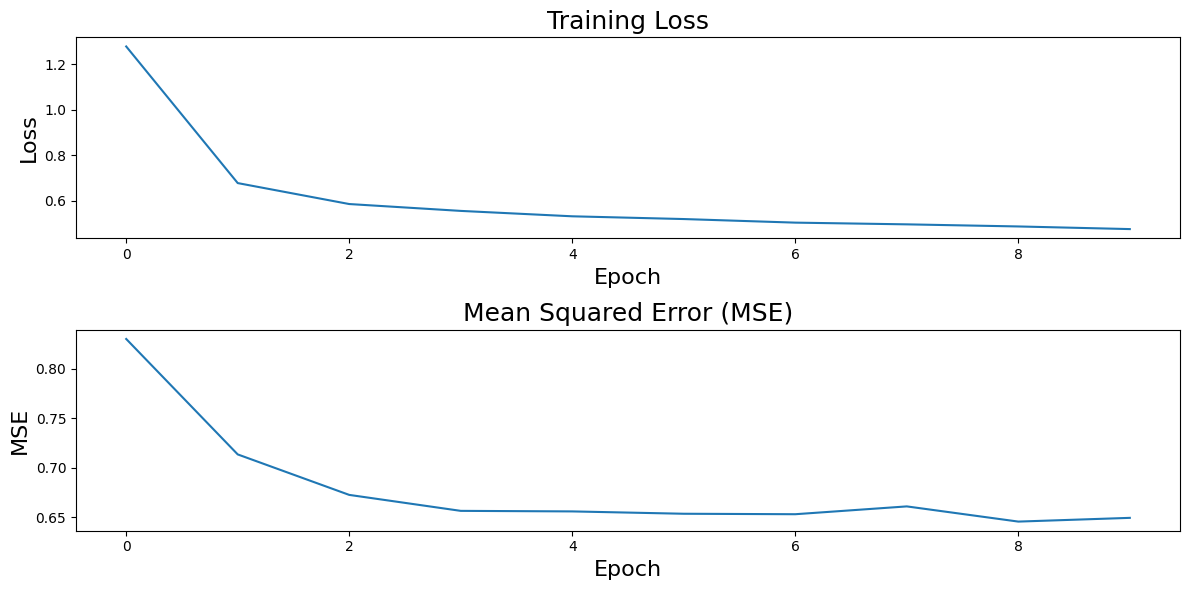

In [11]:
#Plot the results

from sklearn.metrics import mean_squared_error
model = build_model(X_train_scaled.shape[1], y_train.shape[1])

# Create lists to store loss and MSE during training
loss_history = []
mse_history = []

for epoch in range(10):  # Train for 50 epochs
    history = model.fit(X_train_scaled, y_train, epochs=1, batch_size=32, verbose=0)  # Train for 1 epoch
    loss = history.history['loss'][0]

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled, verbose = 0)

    # Calculate Mean Squared Error for each DOA angle
    mse = mean_squared_error(y_test, y_pred)

    # Append the loss and MSE to their respective lists
    loss_history.append(loss)
    mse_history.append(mse)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Training Loss', size = 18)
plt.xlabel('Epoch',size = 16)
plt.ylabel('Loss', size = 16)

# Plot the MSE
plt.subplot(2, 1, 2)
plt.plot(mse_history)
plt.title('Mean Squared Error (MSE)', size =18)
plt.xlabel('Epoch', size = 16)
plt.ylabel('MSE',size=16)

plt.tight_layout()
plt.show()